In [1]:
import tensorflow as tf
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers, losses

In [2]:
!nvidia-smi

Mon Oct  4 13:55:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P0    23W /  N/A |    121MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
IMG_SIZE = 160
IMAGE_SHAPE = [160,160]

In [4]:
def load_images_from_folder(folderName):
    image_list =[]
    for fileIndex in range(7129):
      img = cv2.imread("landscapeImages/"+folderName+"/"+str(fileIndex)+".jpg")
      if folderName == "color": 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        try:
          img = img.reshape(IMG_SIZE,IMG_SIZE,3)
        except:
          img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
          img = img.reshape(IMG_SIZE,IMG_SIZE,3)
      else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        try:
          img = img.reshape(IMG_SIZE,IMG_SIZE,1)
        except:
          img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
          img = img.reshape(IMG_SIZE,IMG_SIZE,1)
      image_list.append(img)
    return image_list
color = np.empty((0,IMG_SIZE,IMG_SIZE,3))
gray = np.empty((0,IMG_SIZE,IMG_SIZE,1))
color  = np.append(color,load_images_from_folder(r"color"),0)
gray  = np.append(gray,load_images_from_folder(r"gray"),0)

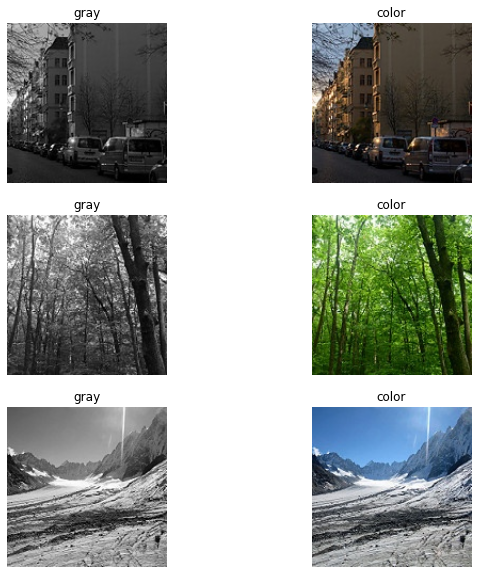

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(0,6,2):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(cv2.cvtColor(gray[i].astype('uint8'), cv2.COLOR_BGR2RGB))
  plt.title("gray")
  plt.axis("off")
  ax = plt.subplot(3, 2, i + 2)
  plt.imshow(color[i].astype('uint8'))
  plt.title("color")
  plt.axis("off")

In [6]:
color /= 255
gray /= 255

In [7]:
def Colorizer(input_shape):
  encoder_input = keras.Input(shape=input_shape)
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1)(encoder_input)
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(x)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
  x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1)(x)
  encoder_output =  layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.UpSampling2D((2, 2))(encoder_output)
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', strides=1)(x)
  decoder_output = layers.UpSampling2D((2, 2))(x)
  return keras.Model(encoder_input, decoder_output, name="decoder")

colorizer = Colorizer((160,160,1))

In [8]:
earlystopping = keras.callbacks.EarlyStopping(
    monitor="accuracy",
    patience=3,
)
colorizer.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [9]:
colorizer.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 80, 80, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 20, 20, 128)       1475

In [10]:
hist = colorizer.fit(gray[:6000], color[:6000],batch_size=2,epochs=15, callbacks = [earlystopping], validation_data = (gray[6000:], color[6000:]))

Epoch 1/15
3000/3000 [==============================] - 35s 9ms/step - loss: 0.0167 - accuracy: 0.4329 - val_loss: 0.0147 - val_accuracy: 0.4542
Epoch 2/15
3000/3000 [==============================] - 27s 9ms/step - loss: 0.0131 - accuracy: 0.4556 - val_loss: 0.0120 - val_accuracy: 0.3899
Epoch 3/15
3000/3000 [==============================] - 26s 9ms/step - loss: 0.0124 - accuracy: 0.4608 - val_loss: 0.0117 - val_accuracy: 0.4906
Epoch 4/15
3000/3000 [==============================] - 26s 9ms/step - loss: 0.0119 - accuracy: 0.4660 - val_loss: 0.0119 - val_accuracy: 0.4697
Epoch 5/15
3000/3000 [==============================] - 27s 9ms/step - loss: 0.0116 - accuracy: 0.4722 - val_loss: 0.0114 - val_accuracy: 0.4186
Epoch 6/15
3000/3000 [==============================] - 27s 9ms/step - loss: 0.0114 - accuracy: 0.4708 - val_loss: 0.0107 - val_accuracy: 0.4517
Epoch 7/15
3000/3000 [==============================] - 27s 9ms/step - loss: 0.0111 - accuracy: 0.4823 - val_loss: 0.0122 - val_ac

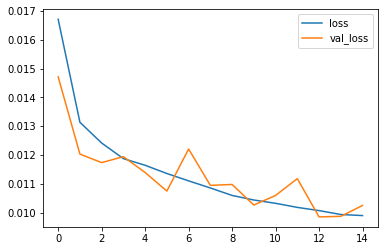

In [32]:
ax = plt.subplot(label= True)
plt.plot(hist.history["loss"], label = "loss")
plt.plot(hist.history["val_loss"], label = "val_loss")
plt.legend(["loss", "val_loss"])

In [12]:
colorized_deneme = colorizer.predict(gray[6000:])

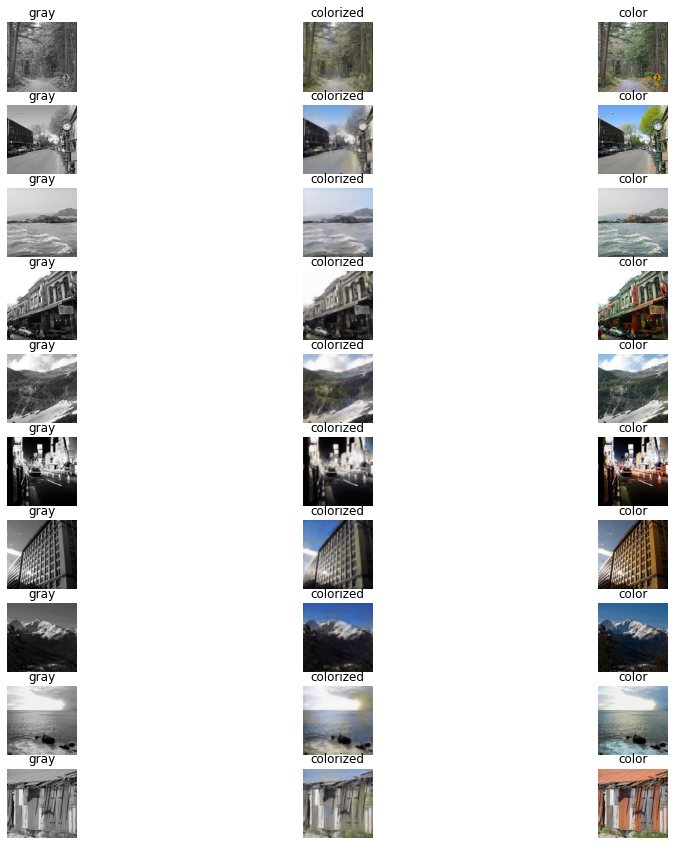

In [37]:
plt.figure(figsize=(15, 15))
for i in range(0,30,3):
  ax = plt.subplot(10, 3, i + 1)
  plt.imshow(cv2.cvtColor(gray[6000+i].astype("float32"), cv2.COLOR_BGR2RGB))
  plt.title("gray")
  plt.axis('off')
  ax = plt.subplot(10, 3, i + 2)
  plt.imshow(colorized_deneme[i])
  plt.title("colorized")
  plt.axis('off')
  ax = plt.subplot(10, 3, i + 3)
  plt.imshow(color[6000+i])
  plt.title("color")
  plt.axis('off')